In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [3]:
phate_dims = 5
df = make_dyngen_data(phate_dims=phate_dims)

Calculating PHATE...
  Running PHATE on 1000 observations and 135 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 4.16 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.28 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.29 seconds.
  Calculating metric MDS...


/Users/davidmetrick/anaconda3/envs/mioflow/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 15.44 seconds.
Calculated PHATE in 20.21 seconds.


In [4]:
df

,samples,d1,d2,d3,d4,d5
0,1.0,-1.627832,-0.413211,-1.158576,-0.244388,-0.211135
2,1.0,-1.585397,-0.612646,-1.044122,-0.152654,-0.037529
4,2.0,-1.260338,-0.946853,-1.162644,-0.109824,-0.017757
5,1.0,-1.620037,-0.879245,-0.892192,-0.168336,-0.037048
6,5.0,2.099371,3.738714,-0.110181,-0.378659,-0.004555
...,...,...,...,...,...,...
987,5.0,2.707203,-2.093988,0.288594,0.063709,0.048253
988,2.0,-0.850791,1.597173,-1.723830,-0.398645,0.180302
991,2.0,-0.808280,-1.669981,-1.024473,-0.290339,-0.076954
992,2.0,-0.536052,-1.868932,-1.036522,-0.331205,-0.097728


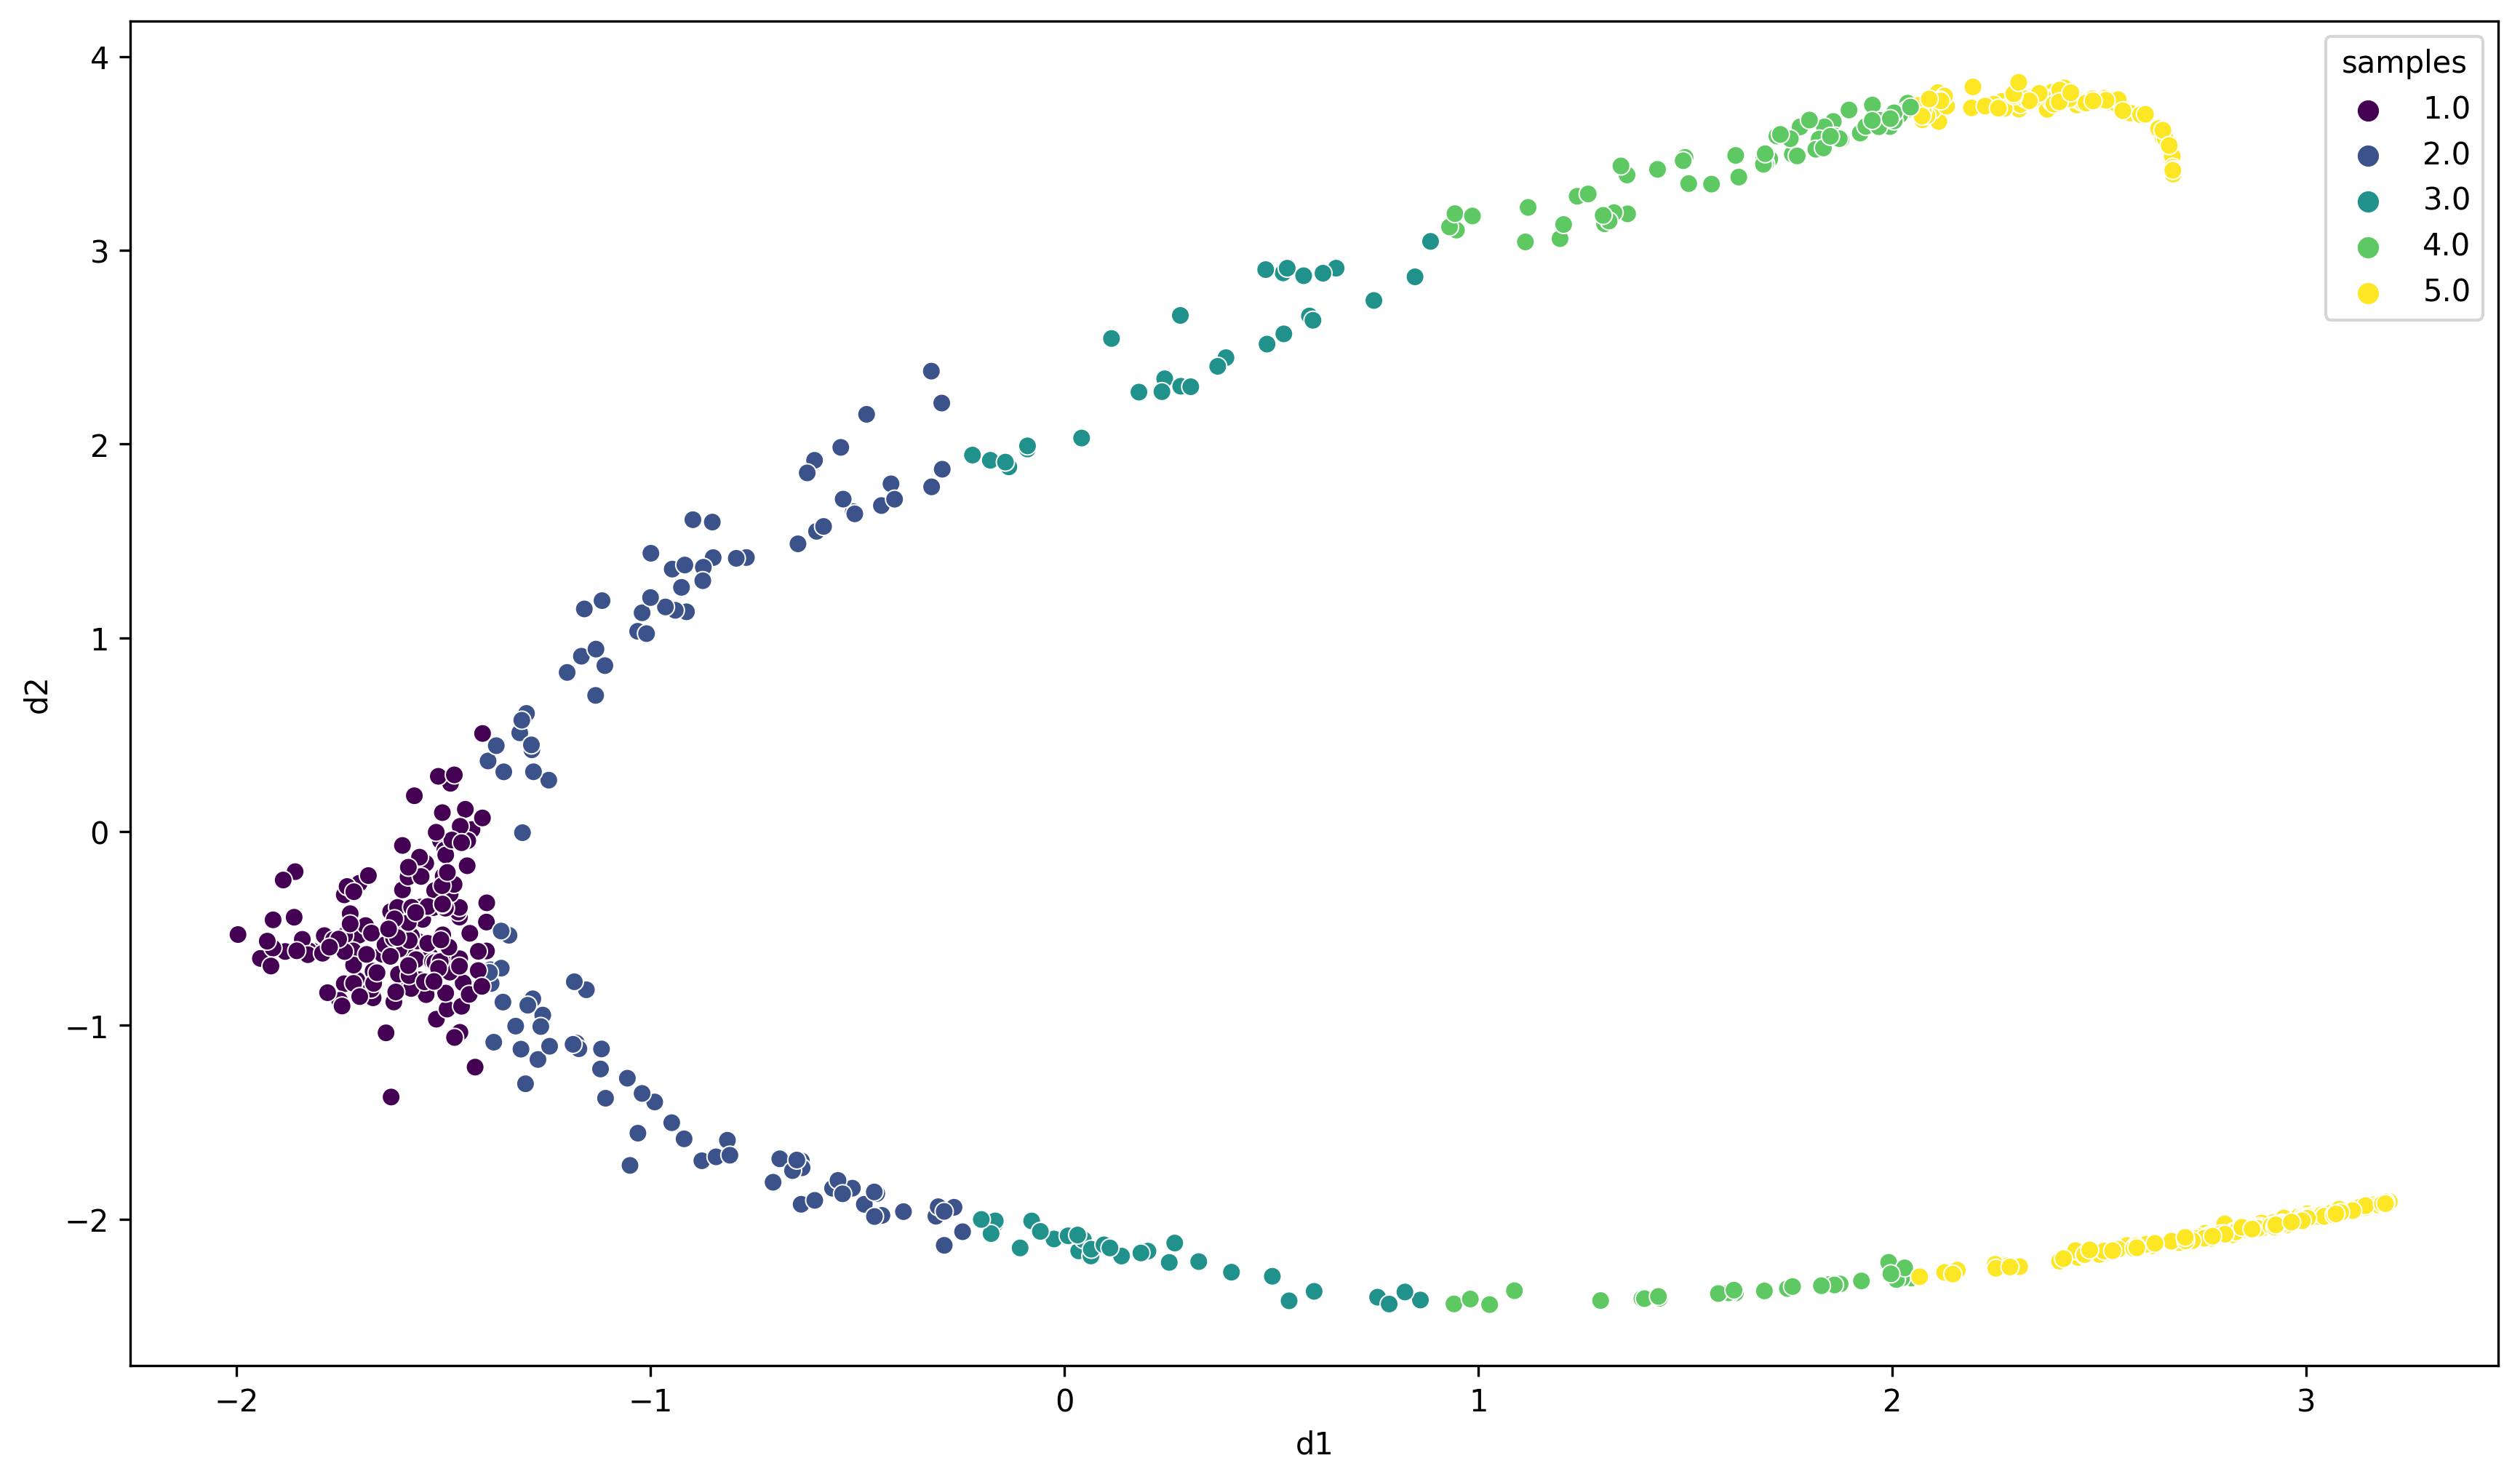

In [5]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [6]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [7]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [8]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = True

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'phate'
rbf_length_scale=0.05
knn=5
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale, knn=knn)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 5
encoder_layers = [model_features, 32, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [9]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.009, noise_max_scale=0.015, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss recon: 1.88225
Train loss dist: 6799.49023
Train loss recon: 1.08392
Train loss dist: 5911.02148
Train loss recon: 0.59663
Train loss dist: 2918.84521
Train loss recon: 0.45399
Train loss dist: 2621.51562
Train loss recon: 0.29309
Train loss dist: 1590.99622
Train loss recon: 0.19623
Train loss dist: 1097.21204
Train loss recon: 0.09674
Train loss dist: 598.00421
Train loss recon: 0.04666
Train loss dist: 643.56976
Train loss recon: 0.04143
Train loss dist: 524.73364
Train loss recon: 0.03735
Train loss dist: 654.3855
Train loss recon: 0.03231
Train loss dist: 418.32822
Train loss recon: 0.03439
Train loss dist: 465.95605
Train loss recon: 0.02325
Train loss dist: 941.03937
Train loss recon: 0.02889
Train loss dist: 814.55414
Train loss recon: 0.0238
Train loss dist: 842.02344
Train loss recon: 0.0199
Train loss dist: 544.61688
Train loss recon: 0.01914
Train loss dist: 655.95776
Train loss recon: 0.02178
Train loss dist: 384.07089
Train loss recon: 0.01773
Train loss dist: 

# Specify parameters

In [10]:
set_seeds(10)

#Directory where results are saved
exp_name = 'dyngen_embcomp'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 5

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.2] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda
)

In [11]:
# Basically "batch size"
sample_size=(60, )

# Training specification
n_local_epochs = 0
n_epochs = 50
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = False
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100 # changed from 100 on all three
n_bins = 100


In [12]:
opts = {
    'phate_dims': phate_dims,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n,
    'knn':knn
}

In [13]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [14]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

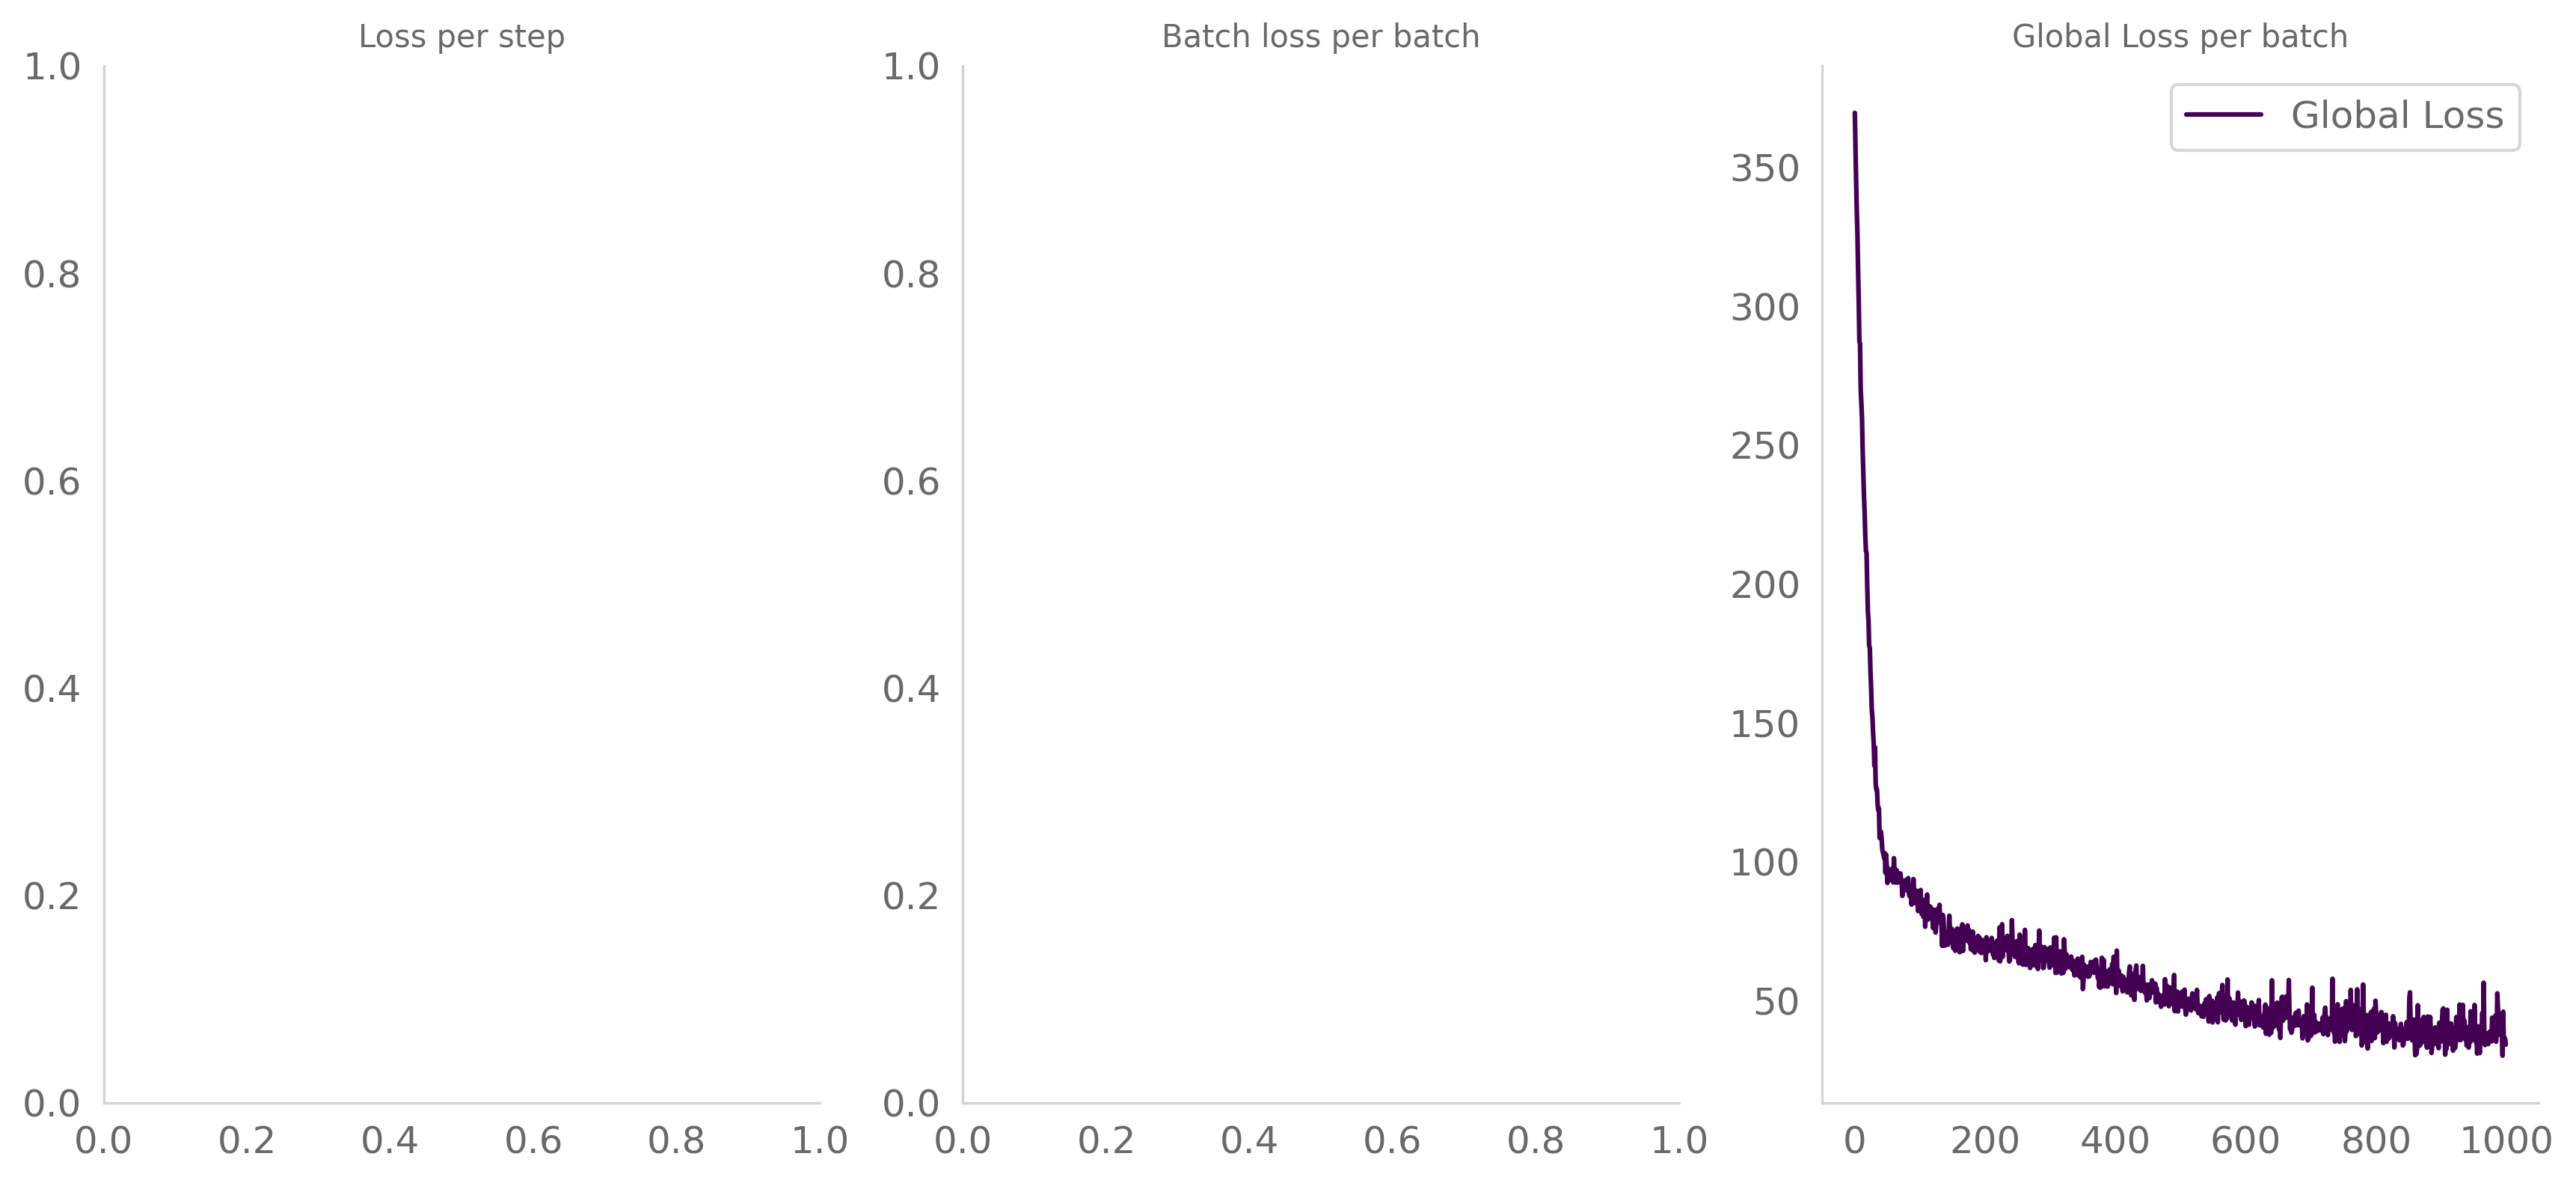

In [15]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [16]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

# Attempt at creating more trajectories, which was meaningless since the model was still missing points

generated_full = generated
trajectories_full = trajectories

for i in range(50):
    generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon)
    
    trajectories_full = np.concatenate((trajectories_full, trajectories), axis=0)
    generated_full = np.concatenate((generated_full, generated), axis=1)

trajectories = trajectories_full
generated = generated_full

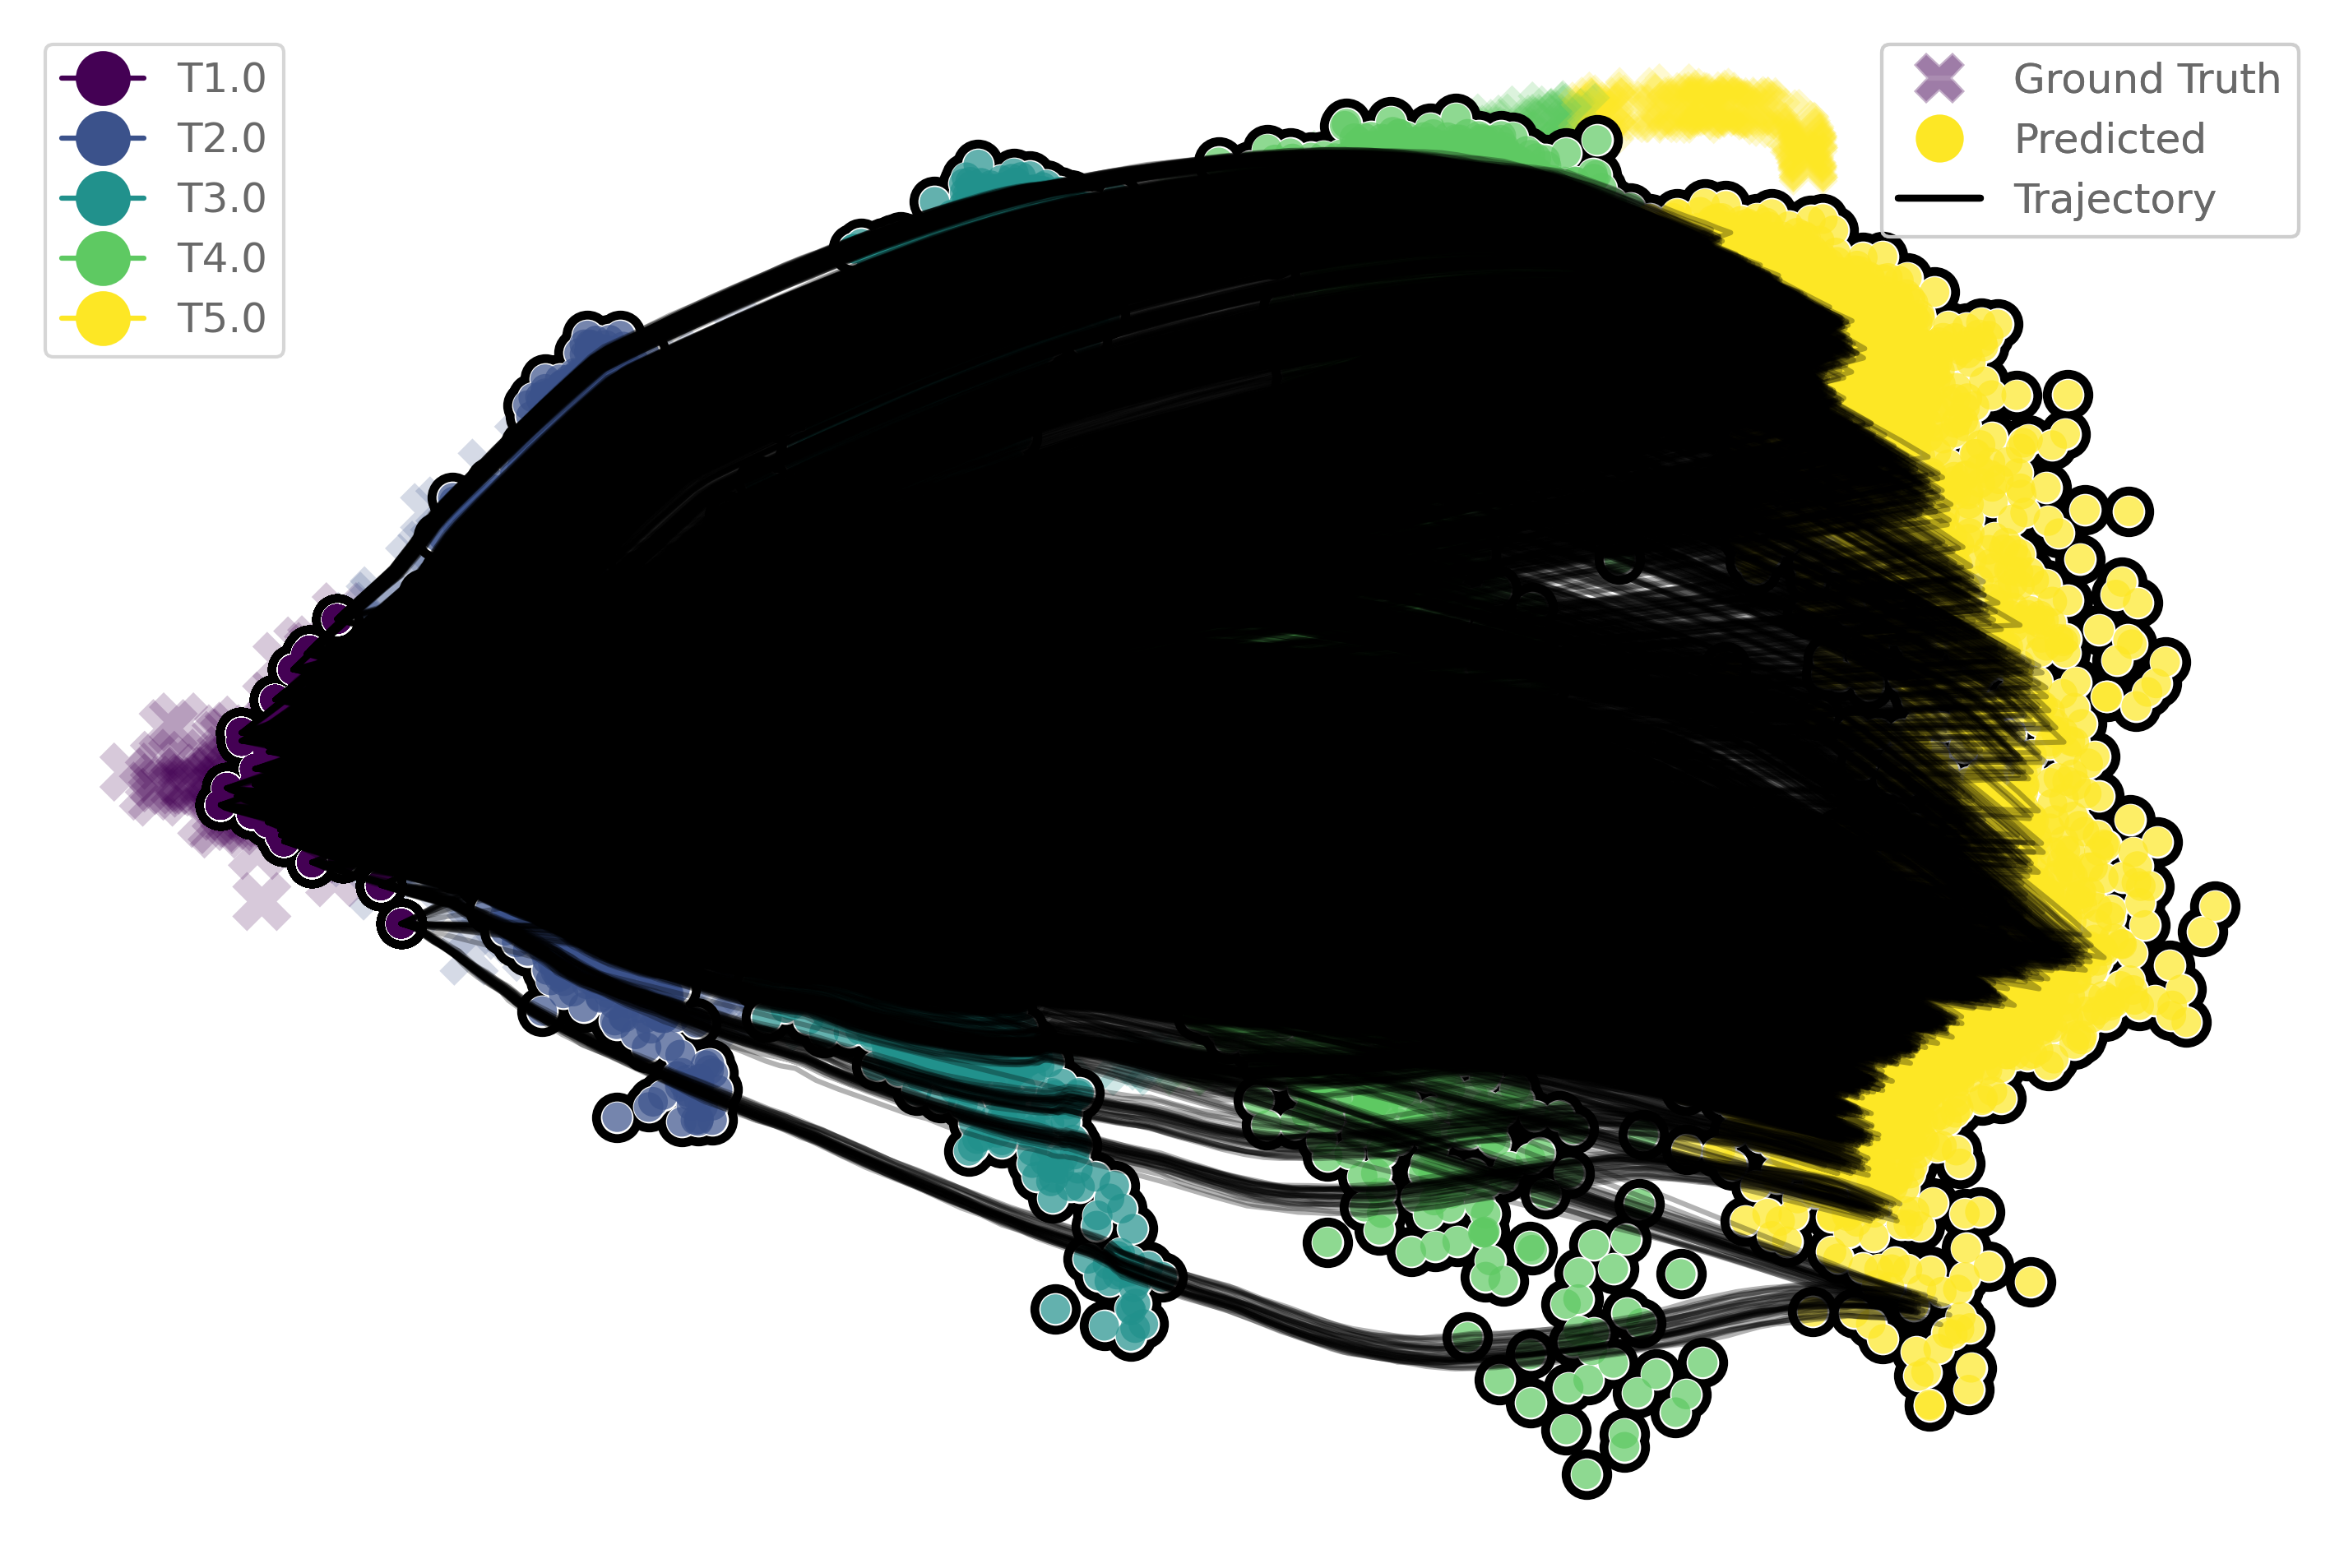

In [17]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

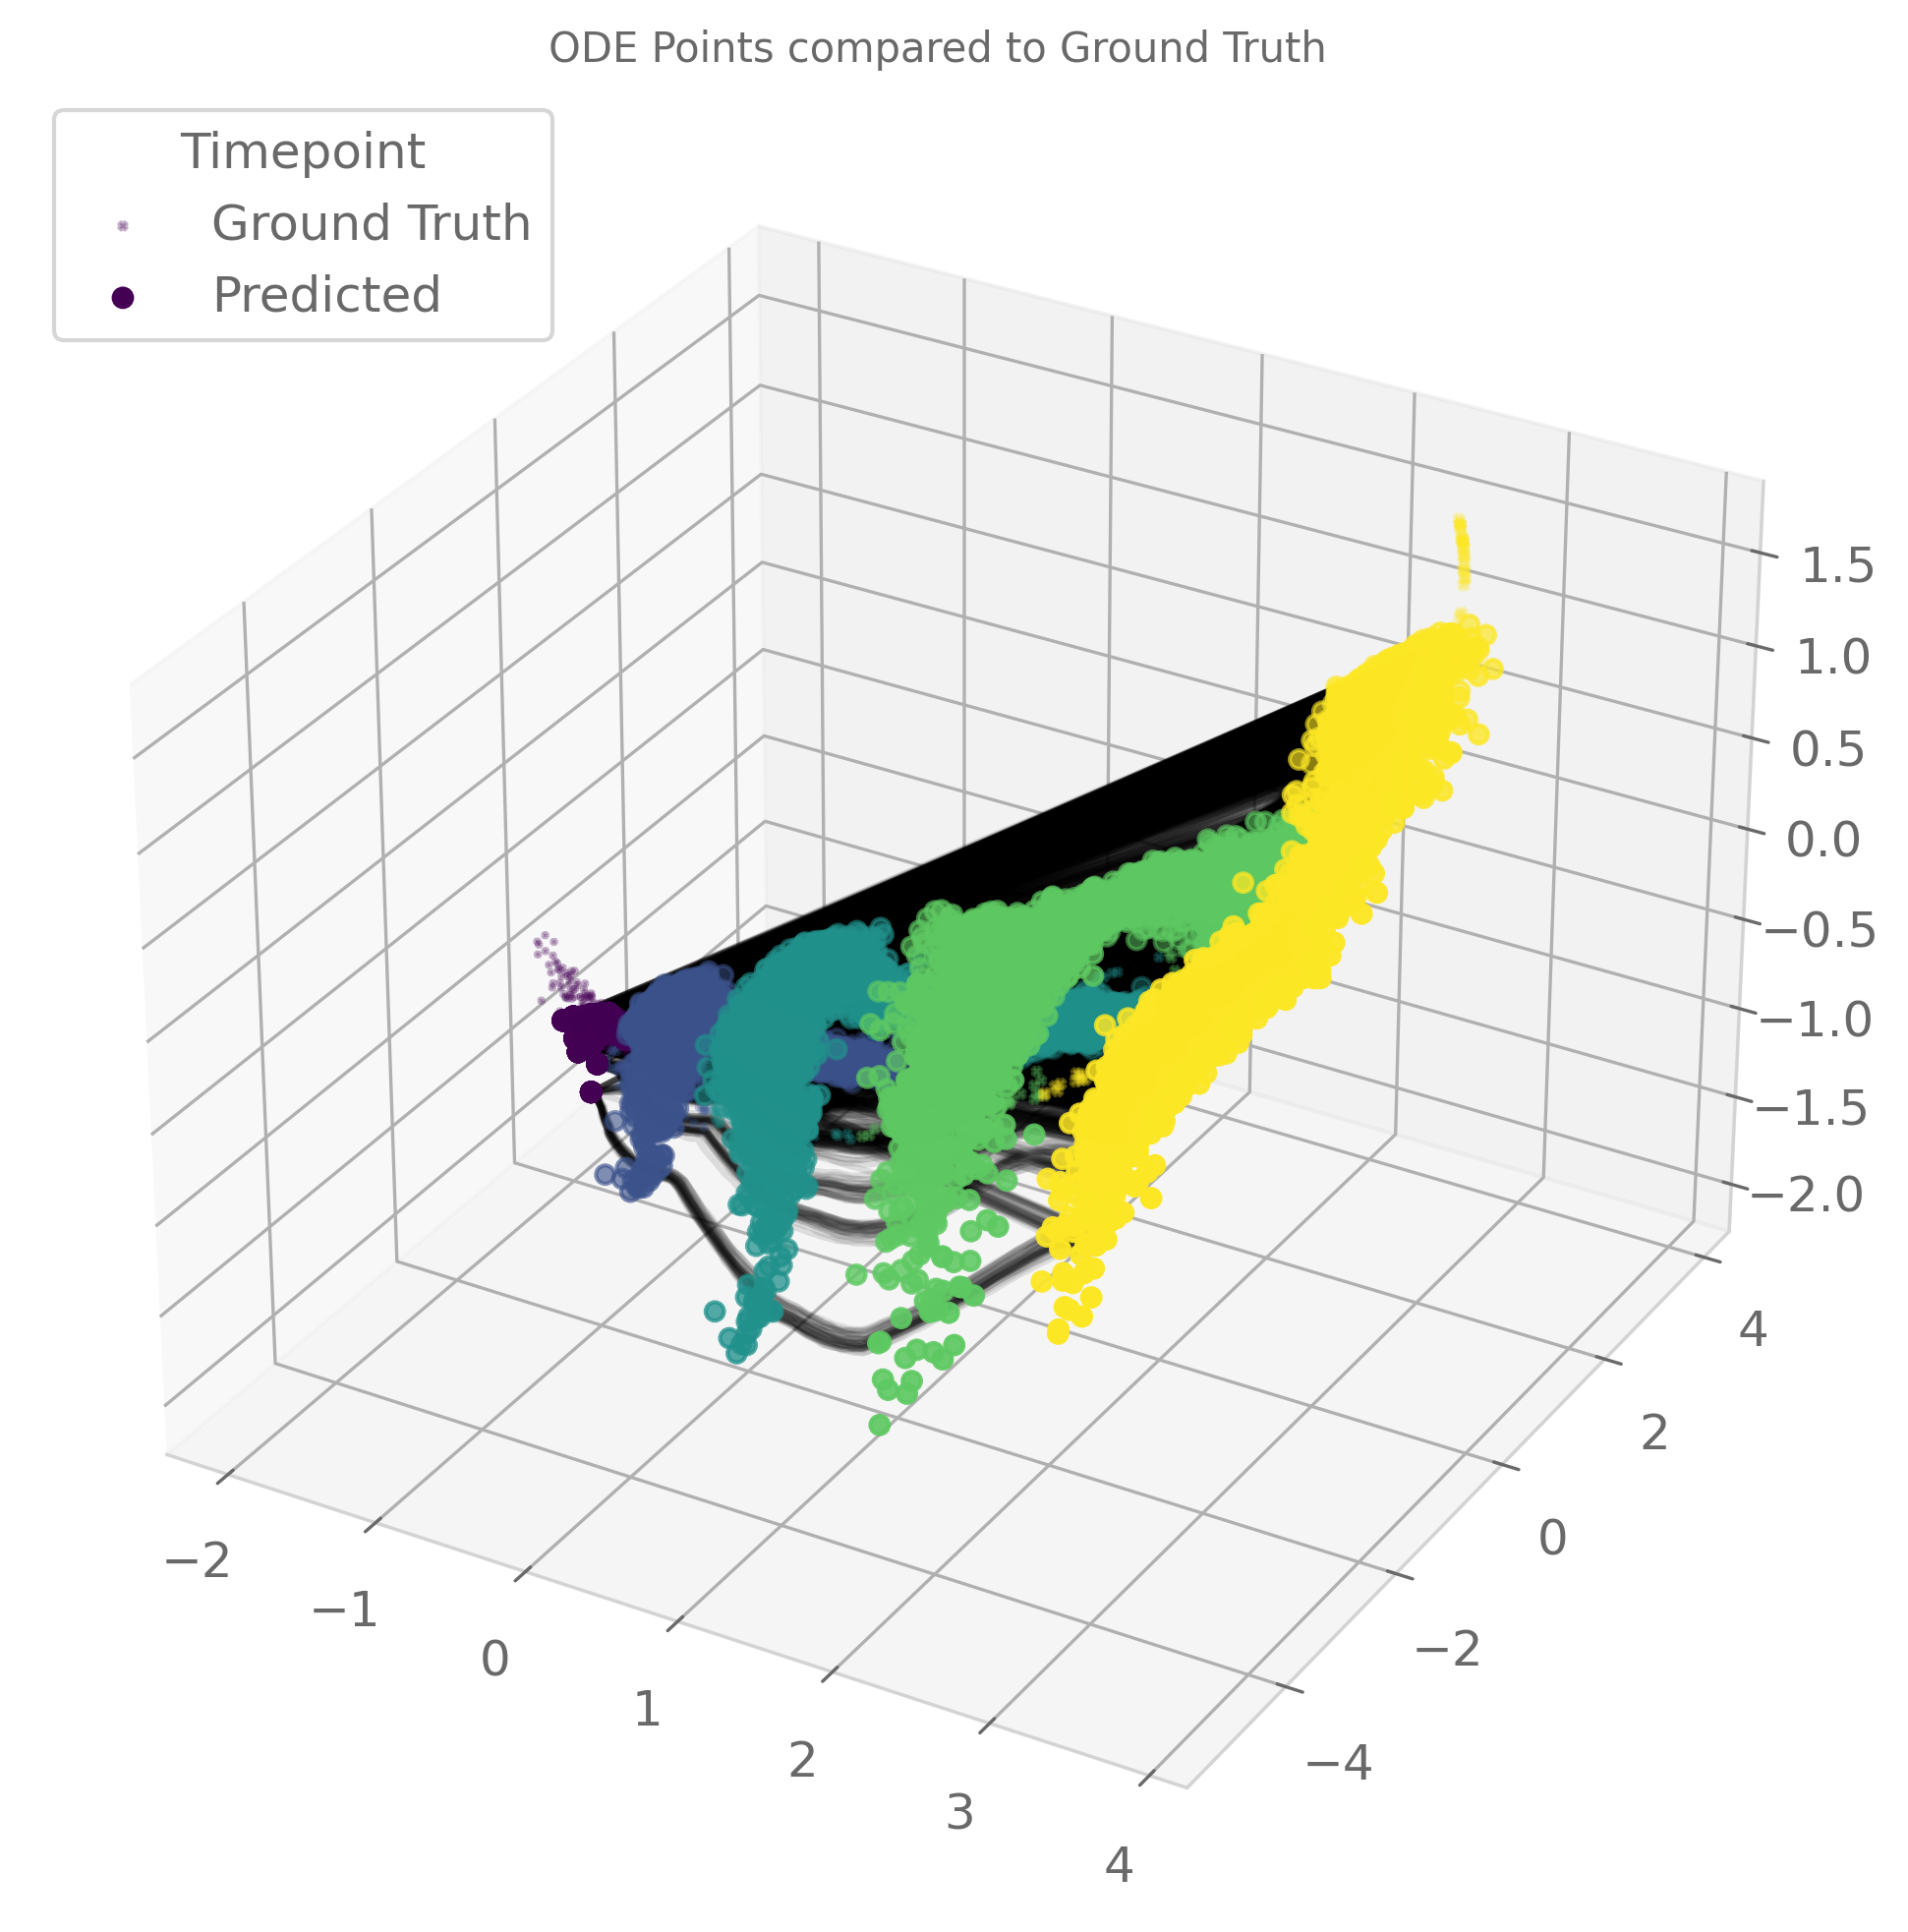

In [18]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='3d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=True
)

In [19]:
# saving the trajectories and generated points
np.save(os.path.join(exp_dir,'trajectories_noemb.npy'),trajectories)
np.save(os.path.join(exp_dir,'generated_noemb.npy'),generated)

In [20]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [21]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [22]:
from MIOFlow.utils import group_extract, sample
import ot
from MIOFlow.losses import MMD_loss
emd_loss = []
mmd_loss = []
for t in groups[1:]:
    set_seeds(10)
    xs = generated[int(t-1),:60]
    xt = sample(df,group=t,size=60)
    xs.shape,xt.shape
    a = torch.tensor(ot.unif(xs.shape[0]))
    b = torch.tensor(ot.unif(xt.shape[0]))
    M = ot.dist(xs, xt, metric='euclidean')
    emd_loss.append(ot.emd2(a, b, torch.tensor(M)))
    mmd = MMD_loss()
    mmd_loss.append(mmd.forward(torch.tensor(xs),torch.tensor(xt)))
f = open(exp_dir+"/metric.txt", "a")
f.write('\nAlpha 15 mean EMD :'+str(np.mean(emd_loss))+' MMD mean : '+str(np.mean(mmd_loss))+'\n')
f.close()

In [23]:
generated.shape

(5, 5100, 5)

In [24]:
df

,samples,d1,d2,d3,d4,d5
0,1.0,-1.627832,-0.413211,-1.158576,-0.244388,-0.211135
2,1.0,-1.585397,-0.612646,-1.044122,-0.152654,-0.037529
4,2.0,-1.260338,-0.946853,-1.162644,-0.109824,-0.017757
5,1.0,-1.620037,-0.879245,-0.892192,-0.168336,-0.037048
6,5.0,2.099371,3.738714,-0.110181,-0.378659,-0.004555
...,...,...,...,...,...,...
987,5.0,2.707203,-2.093988,0.288594,0.063709,0.048253
988,2.0,-0.850791,1.597173,-1.723830,-0.398645,0.180302
991,2.0,-0.808280,-1.669981,-1.024473,-0.290339,-0.076954
992,2.0,-0.536052,-1.868932,-1.036522,-0.331205,-0.097728


In [25]:
df2 = pd.read_csv("~/MIOFlow/data/cell_info.csv")

In [26]:
df2

,cell_id,step_ix,simulation_i,sim_time,Unnamed: 4,Unnamed: 5
0,cell1,4798.0,9.0,264.000000,NaN,NaN
1,cell2,4135.0,8.0,86.083333,NaN,NaN
2,cell3,3600.0,7.0,164.000000,NaN,NaN
3,cell4,4132.0,8.0,80.083333,NaN,NaN
4,cell5,2469.0,5.0,198.000000,NaN,NaN
...,...,...,...,...,...,...
996,cell997,1278.0,3.0,112.083333,NaN,NaN
997,cell998,73.0,1.0,0.000000,NaN,NaN
998,cell999,4725.0,9.0,118.083333,NaN,NaN
999,cell1000,2982.0,6.0,76.000000,NaN,NaN


In [27]:
df3 = pd.read_csv("~/MIOFlow/data/dyngen_expression_bif.csv")

In [28]:
df3

,Burn1_TF1,Burn2_TF1,Burn3_TF1,Burn4_TF1,A1_TF1,A2_TF1,A3_TF1,A4_TF1,A5_TF1,A6_TF1,...,HK41,HK42,HK43,HK44,HK45,HK46,HK47,HK48,HK49,HK50
0,1.000000,1.584963,2.000000,2.321928,1.584963,2.000000,0.000000,1.000000,3.459432,1.584963,...,3.000000,2.321928,2.321928,1.584963,0.0,1.584963,0.000000,0.0,3.169925,0.000000
1,1.000000,1.000000,3.000000,2.584963,0.000000,2.000000,2.321928,1.584963,2.321928,0.000000,...,2.807355,2.321928,3.321928,2.000000,0.0,3.000000,1.000000,0.0,3.000000,0.000000
2,1.584963,2.000000,1.000000,1.584963,2.321928,1.000000,1.000000,2.807355,2.584963,1.000000,...,3.000000,2.584963,3.459432,1.000000,0.0,1.584963,2.584963,0.0,2.584963,0.000000
3,1.000000,1.584963,2.000000,2.321928,2.584963,2.000000,2.000000,1.584963,1.584963,0.000000,...,2.584963,3.000000,1.584963,0.000000,0.0,1.000000,1.000000,0.0,1.584963,0.000000
4,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,2.321928,...,1.584963,3.321928,3.321928,1.584963,0.0,1.584963,2.807355,0.0,3.321928,1.584963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.321928,2.584963,2.584963,3.000000,1.584963,1.584963,1.584963,1.584963,2.321928,1.584963,...,3.169925,2.807355,3.169925,2.807355,0.0,2.807355,2.807355,0.0,3.169925,0.000000
996,2.321928,1.584963,1.000000,2.321928,2.321928,1.000000,2.000000,1.000000,2.584963,0.000000,...,2.584963,2.807355,3.459432,1.584963,0.0,1.000000,2.000000,0.0,2.321928,0.000000
997,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.321928,2.807355,4.754888,1.584963,1.0,0.000000,1.000000,0.0,2.321928,0.000000
998,2.584963,2.000000,2.807355,0.000000,1.000000,2.321928,2.584963,2.000000,3.000000,1.000000,...,3.169925,2.807355,3.321928,1.584963,0.0,2.321928,0.000000,0.0,2.584963,0.000000


In [29]:
df

,samples,d1,d2,d3,d4,d5
0,1.0,-1.627832,-0.413211,-1.158576,-0.244388,-0.211135
2,1.0,-1.585397,-0.612646,-1.044122,-0.152654,-0.037529
4,2.0,-1.260338,-0.946853,-1.162644,-0.109824,-0.017757
5,1.0,-1.620037,-0.879245,-0.892192,-0.168336,-0.037048
6,5.0,2.099371,3.738714,-0.110181,-0.378659,-0.004555
...,...,...,...,...,...,...
987,5.0,2.707203,-2.093988,0.288594,0.063709,0.048253
988,2.0,-0.850791,1.597173,-1.723830,-0.398645,0.180302
991,2.0,-0.808280,-1.669981,-1.024473,-0.290339,-0.076954
992,2.0,-0.536052,-1.868932,-1.036522,-0.331205,-0.097728


In [30]:
df.index.tolist()

[0,
 2,
 4,
 5,
 6,
 7,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 25,
 28,
 29,
 30,
 32,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 46,
 47,
 48,
 50,
 51,
 52,
 53,
 55,
 58,
 59,
 60,
 62,
 64,
 65,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 76,
 78,
 79,
 81,
 83,
 84,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 111,
 112,
 113,
 115,
 116,
 117,
 118,
 121,
 123,
 124,
 125,
 126,
 127,
 129,
 130,
 131,
 132,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 157,
 158,
 160,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 170,
 171,
 172,
 174,
 175,
 176,
 177,
 178,
 179,
 181,
 182,
 183,
 185,
 186,
 189,
 191,
 193,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 209,
 211,
 212,
 213,
 215,
 216,
 217,
 218,
 220,
 221,
 222,
 225,
 226,
 228,
 229,
 230,
 233,
 234,
 236,
 237,
 238,
 239,
 240,
 242,
 247,
 248,
 250,
 251,
 252,
 

In [31]:
raw_data = df3.loc[df.index.tolist()]

In [32]:
df.to_csv("dyngen_PCs.csv", index=False)

In [33]:
np.save('trajectories.npy', trajectories)

In [34]:
trajectories

array([[[-1.4807668 , -0.18996942, -1.23287   , -0.07566172,
         -0.1018838 ],
        [-1.5985785 , -0.27139708, -1.2501457 , -0.09586739,
         -0.11047897],
        [-1.6458642 , -0.51008207, -1.1428676 , -0.17495078,
         -0.07729912],
        ...,
        [-1.4248836 ,  0.18814048, -1.3800535 , -0.03840812,
         -0.03149716],
        [-1.5093465 , -0.74702716, -0.99096334, -0.14914437,
         -0.08097997],
        [-1.5885406 , -0.6398668 , -1.0543038 , -0.1501637 ,
         -0.06570901]],

       [[-1.4620562 , -0.1590003 , -1.2381872 , -0.07331925,
         -0.09312885],
        [-1.5807626 , -0.2414722 , -1.2589663 , -0.09546073,
         -0.10888444],
        [-1.633224  , -0.50937986, -1.1380874 , -0.17724025,
         -0.07178043],
        ...,
        [-1.3982518 ,  0.245859  , -1.3927214 , -0.03680248,
         -0.01941916],
        [-1.4916945 , -0.75378025, -0.98285055, -0.15336668,
         -0.08129585],
        [-1.5745239 , -0.64420307, -1.0456464 , 

In [35]:
np.load(os.path.join(exp_dir,'trajectories_noemb.npy'))

array([[[-1.4807668 , -0.18996942, -1.23287   , -0.07566172,
         -0.1018838 ],
        [-1.5985785 , -0.27139708, -1.2501457 , -0.09586739,
         -0.11047897],
        [-1.6458642 , -0.51008207, -1.1428676 , -0.17495078,
         -0.07729912],
        ...,
        [-1.4248836 ,  0.18814048, -1.3800535 , -0.03840812,
         -0.03149716],
        [-1.5093465 , -0.74702716, -0.99096334, -0.14914437,
         -0.08097997],
        [-1.5885406 , -0.6398668 , -1.0543038 , -0.1501637 ,
         -0.06570901]],

       [[-1.4620562 , -0.1590003 , -1.2381872 , -0.07331925,
         -0.09312885],
        [-1.5807626 , -0.2414722 , -1.2589663 , -0.09546073,
         -0.10888444],
        [-1.633224  , -0.50937986, -1.1380874 , -0.17724025,
         -0.07178043],
        ...,
        [-1.3982518 ,  0.245859  , -1.3927214 , -0.03680248,
         -0.01941916],
        [-1.4916945 , -0.75378025, -0.98285055, -0.15336668,
         -0.08129585],
        [-1.5745239 , -0.64420307, -1.0456464 , 

In [36]:
exp_dir

'/Users/davidmetrick/MIOFlow/results/dyngen_embcomp'

In [37]:
np.load('/Users/davidmetrick/MIOFlow/results/dyngen_embcomp/trajectories_noemb.npy')

array([[[-1.4807668 , -0.18996942, -1.23287   , -0.07566172,
         -0.1018838 ],
        [-1.5985785 , -0.27139708, -1.2501457 , -0.09586739,
         -0.11047897],
        [-1.6458642 , -0.51008207, -1.1428676 , -0.17495078,
         -0.07729912],
        ...,
        [-1.4248836 ,  0.18814048, -1.3800535 , -0.03840812,
         -0.03149716],
        [-1.5093465 , -0.74702716, -0.99096334, -0.14914437,
         -0.08097997],
        [-1.5885406 , -0.6398668 , -1.0543038 , -0.1501637 ,
         -0.06570901]],

       [[-1.4620562 , -0.1590003 , -1.2381872 , -0.07331925,
         -0.09312885],
        [-1.5807626 , -0.2414722 , -1.2589663 , -0.09546073,
         -0.10888444],
        [-1.633224  , -0.50937986, -1.1380874 , -0.17724025,
         -0.07178043],
        ...,
        [-1.3982518 ,  0.245859  , -1.3927214 , -0.03680248,
         -0.01941916],
        [-1.4916945 , -0.75378025, -0.98285055, -0.15336668,
         -0.08129585],
        [-1.5745239 , -0.64420307, -1.0456464 , 

In [38]:
df

,samples,d1,d2,d3,d4,d5
0,1.0,-1.627832,-0.413211,-1.158576,-0.244388,-0.211135
2,1.0,-1.585397,-0.612646,-1.044122,-0.152654,-0.037529
4,2.0,-1.260338,-0.946853,-1.162644,-0.109824,-0.017757
5,1.0,-1.620037,-0.879245,-0.892192,-0.168336,-0.037048
6,5.0,2.099371,3.738714,-0.110181,-0.378659,-0.004555
...,...,...,...,...,...,...
987,5.0,2.707203,-2.093988,0.288594,0.063709,0.048253
988,2.0,-0.850791,1.597173,-1.723830,-0.398645,0.180302
991,2.0,-0.808280,-1.669981,-1.024473,-0.290339,-0.076954
992,2.0,-0.536052,-1.868932,-1.036522,-0.331205,-0.097728


In [39]:
trajectories.shape

(5100, 100, 5)

In [40]:
generated.shape

(5, 5100, 5)

In [41]:
type(trajectories)

numpy.ndarray

In [42]:
type(generated)

numpy.ndarray